<a href="https://colab.research.google.com/github/Victorlouisdg/simulators/blob/main/collisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install meshzoo

In [2]:
from collections import namedtuple
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import meshzoo
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D, proj3d
from IPython.display import HTML
matplotlib.rc('animation', html='jshtml')

In [3]:
vertex_positions_uv, triangle_vertex_indices = meshzoo.rectangle_tri(
    (0.0, 0.0),
    (1.0, 1.0),
    n=2,
    variant="zigzag",  # or "up", "down", "center"
)

In [4]:
n_vertices = vertex_positions_uv.shape[0]

def init_flat(vertex_positions_uv):
    vertex_positions_z = np.zeros(n_vertices)
    vertex_positions = np.column_stack([vertex_positions_uv, vertex_positions_z]).flatten()
    return vertex_positions

vertex_positions = init_flat(vertex_positions_uv)

In [5]:
def plot_cloth(ax, vertex_positions, triangle_vertex_indices):
    # x, y, z = vertex_positions.transpose()
    x = vertex_positions[0::3]
    y = vertex_positions[1::3]
    z = vertex_positions[2::3]

    ax.clear()  # necessary for the animations
    ax.plot_trisurf(x, y, z, triangles=triangle_vertex_indices, color='deepskyblue', alpha=0.7)
    ax.scatter(x, y, z, c='deeppink', s=20, depthshade=False)
    for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
        ax.text(xi, yi, zi, str(i), fontsize='medium', color='black', zorder=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_zlim([-1, 1])

class Arrow3D(FancyArrowPatch):
    # Arrow plotting code from: 
    # https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


def plot_arrow(ax, start, vector, color='mediumseagreen', scale=1.0):
    end = start + scale * vector
    x0, y0, z0 = start
    x1, y1, z1 = end
    a = Arrow3D([x0, x1], [y0, y1], [z0, z1], mutation_scale=10, lw=3, arrowstyle="-|>", color=color, zorder=10)
    ax.add_artist(a)

In [6]:
def slice3(i):
    return slice(3*i, 3*i+3)

triangle 0
0.25
df -0.1
0.35355339059327373
df -0.1
0.25
df -0.1
triangle 1
-0.35355339059327373
df -0.1
0.75
df -0.1
0.75
df -0.1


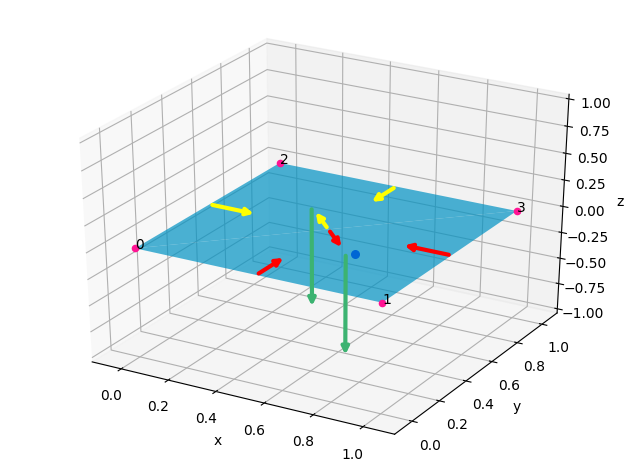

In [7]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111, projection='3d')
plot_cloth(ax, vertex_positions, triangle_vertex_indices)
# plot_arrow(ax, np.array((0, 0, 0)), np.array((0, 0, 0.5)))

xp = np.array((0.75, 0.25, 0.1))
ax.scatter(xp[0], xp[1], xp[2], c='blue', s=30, depthshade=False , zorder=10);

n_triangles = len(triangle_vertex_indices)

triangle_index = 0


normals = []

for triangle_index in range(n_triangles):
    v0, v1, v2 = triangle_vertex_indices[triangle_index]
    x0 = vertex_positions[slice3(v0)]
    x1 = vertex_positions[slice3(v1)]
    x2 = vertex_positions[slice3(v2)]

    # TODO change this to edge normal instead of triangle normal
    normal = np.cross(x2 - x0, x1 - x0)
    normal = normal / np.linalg.norm(normal)

    center = (x0 + x1 + x2) / 3
    plot_arrow(ax, center, normal)

    vertices = (x0, x1, x2)

    print('triangle', triangle_index)

    for i in range(3):
        for j in range(3):
            if i < j:
                k = 3 - i - j
                xi = vertices[i]
                xj = vertices[j]
                xk = vertices[k]

                e_ij = xj - xi
                e_bisector_normal = np.cross(normal, e_ij)
        
                if(np.dot(e_bisector_normal, xk - (xi + xj) / 2) < 0):
                    e_bisector_normal = -e_bisector_normal

                e_bisector_normal = e_bisector_normal / np.linalg.norm(e_bisector_normal)

                d_eplane = np.dot(e_bisector_normal, xp - xj)
                print(d_eplane)

                d_fplane = np.dot(normal, xp - x0)

                print('df', d_fplane)

                color = 'red' if triangle_index == 0 else 'yellow'
                plot_arrow(ax, (xi + xj) / 2, e_bisector_normal, color=color, scale=0.2)